<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Import-Packages-&amp;-Data" data-toc-modified-id="Import-Packages-&amp;-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Packages &amp; Data</a></span></li><li><span><a href="#Clean-&amp;-Explore-Data" data-toc-modified-id="Clean-&amp;-Explore-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean &amp; Explore Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Warehouse" data-toc-modified-id="Warehouse-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Warehouse</a></span><ul class="toc-item"><li><span><a href="#Value-Counts" data-toc-modified-id="Value-Counts-4.0.1.1"><span class="toc-item-num">4.0.1.1&nbsp;&nbsp;</span>Value Counts</a></span></li><li><span><a href="#Order-Demand" data-toc-modified-id="Order-Demand-4.0.1.2"><span class="toc-item-num">4.0.1.2&nbsp;&nbsp;</span>Order Demand</a></span></li></ul></li><li><span><a href="#Products" data-toc-modified-id="Products-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Products</a></span></li><li><span><a href="#Product-Category" data-toc-modified-id="Product-Category-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>Product Category</a></span></li></ul></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Build-&amp;-Fit-Baseline-Model" data-toc-modified-id="Build-&amp;-Fit-Baseline-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Build &amp; Fit Baseline Model</a></span></li><li><span><a href="#Forecasting-&amp;-Predictions" data-toc-modified-id="Forecasting-&amp;-Predictions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Forecasting &amp; Predictions</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Results" data-toc-modified-id="Results-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Recommendations" data-toc-modified-id="Recommendations-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Recommendations</a></span></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Future Work</a></span></li></ul></li></ul></div>

# Intro

# Import Packages & Data

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from fbprophet import Prophet

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

import datetime

# Formatting for plots
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 22}

plt.rc('font', **font)

In [2]:
# Import Data

data = pd.read_csv('Historical_Product_Demand.csv')
df = pd.DataFrame(data)

In [3]:
# Preview Data

df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Clean & Explore Data

Since we're fitting time series models, we're going to want to change the Date column to be in datetime format and set it as the index. We'll explore a bit first before getting to that. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
Product_Code        999999 non-null object
Warehouse           999999 non-null object
Product_Category    999999 non-null object
Date                988760 non-null object
Order_Demand        999999 non-null int64
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


We can see the 'Date' column has fewer values than the rest of the columns, which indicates missing data. It doesn't look like much of the data are missing, so if they're indeed null, then we can go ahead and drop those rows.

We can also see that basically every category other than 'Order_Demand' are objects. That's totally fine as we will use them to categorize, however our time series will simply be date and demand.

Let's take a look at our summary statistics for order demand.

In [5]:
# Summary statistics
df.describe().round()

,Order_Demand
count,999999.0
mean,5071.0
std,29603.0
min,-999000.0
25%,20.0
50%,300.0
75%,2000.0
max,4000000.0


With a minimum of -999000.0, it looks like this may be a null value, so we can search for those nulls as well.

Let's go ahead and get those rows with null date values removed, and then change our date column into datetime format and rather than set to index actually, we will set it to Facebook Profit's special 'ds' column.

In [6]:
df[df.Order_Demand == -999000]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
585144,Product_1241,Whse_J,Category_019,2014/3/27,-999000


In [7]:
df.isnull().any()

Product_Code        False
Warehouse           False
Product_Category    False
Date                 True
Order_Demand        False
dtype: bool

In [8]:
df[df.Date.isnull() == True]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
45460,Product_1461,Whse_A,Category_019,NaN,10000
456373,Product_1636,Whse_A,Category_019,NaN,100
456374,Product_1461,Whse_A,Category_019,NaN,300
456375,Product_1464,Whse_A,Category_019,NaN,300
456376,Product_1388,Whse_A,Category_019,NaN,200
...,...,...,...,...,...
995790,Product_1464,Whse_A,Category_019,NaN,-900
995791,Product_1541,Whse_A,Category_019,NaN,-200
995792,Product_1388,Whse_A,Category_019,NaN,-300
995793,Product_1541,Whse_A,Category_019,NaN,-300


This looks like a lot of rows, and that they're all from Warehouse A. Some of them appear to have negative demand as well. Let's take a closer look. 

In [9]:
whse_a = df[df.Warehouse == 'Whse_A']
whse_a

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
34593,Product_0905,Whse_A,Category_023,2012/3/7,50
41029,Product_0097,Whse_A,Category_019,2012/1/18,6000
41030,Product_1496,Whse_A,Category_019,2012/3/13,5000
41031,Product_0097,Whse_A,Category_019,2012/4/16,6000
41032,Product_0097,Whse_A,Category_019,2012/9/24,3900
...,...,...,...,...,...
995797,Product_1822,Whse_A,Category_018,2016/3/1,2
995798,Product_1470,Whse_A,Category_019,2016/5/19,100
995799,Product_0599,Whse_A,Category_017,2016/9/15,12
995800,Product_0599,Whse_A,Category_017,2016/10/26,10


We can see that 11240/153574 of the values are null. There's really no other way to interpolate time data for a warehouse with a NaN value for date, so we're going to remove it. 

We can also check to see how many rows we have for the other warehouses for comparison. 

In [10]:
df.Warehouse.value_counts()

Whse_J    715944
Whse_A    153574
Whse_S     88127
Whse_C     42354
Name: Warehouse, dtype: int64

We can see that Warehouse A is the second largest warehouse. There is a decent amount of variance among the warehouses, so it doesn't seem to be much of an issue to remove the rows.

Let's drop the null values.

In [11]:
# Drop rows with NaN values (which were only in Date column)
df = df.dropna()

In [12]:
# Get index of row with large negative order demand 
df[df.Order_Demand == -999000]

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
585144,Product_1241,Whse_J,Category_019,2014/3/27,-999000


In [13]:
# Drop row 
df = df.drop(index=585144)

Now we'll set the Date column to datetime format.

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988759 entries, 0 to 999998
Data columns (total 5 columns):
Product_Code        988759 non-null object
Warehouse           988759 non-null object
Product_Category    988759 non-null object
Date                988759 non-null datetime64[ns]
Order_Demand        988759 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 45.3+ MB


Great! Now our Date column is set to datetime format so we can subset our data as needed and create time series from it. Now, to the visual exploration (EDA)!

# EDA 

Let's take a look at product demand for the entire time series. Note: I zoomed in on the x-axis as 2011 data was significantly lower. We'll take a closer look at 2011 following this plot.

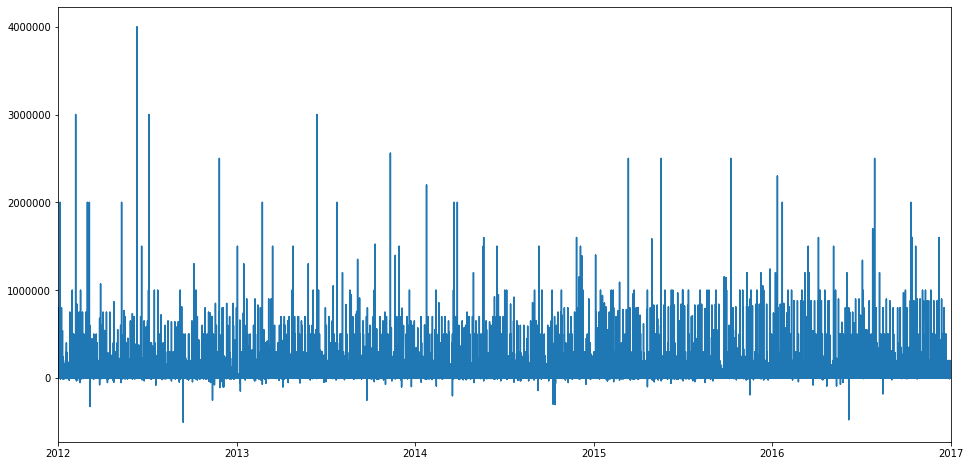

In [15]:
# Plot demand data for entire dataset

# Sort by date first for plotting
df = df.sort_values('Date')

# Set x & y
x = df.Date
y = df.Order_Demand

# Plot
plt.figure(figsize=(16,8))
plt.plot(x, y)

# Set x-axis limits (low demand data for 2011 - may be able to remove this year)
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2017, 1, 1)]);

We can see a really big spike mid 2012. I wonder why? Perhaps there was a promotion or a new product launch or something similar? The demand seems pretty consistent through out the years with a slight drop in Q3 of 2014. 

Let's get a closer look at 2011 (not pictured here as I intentionally zoomed in on the axis for a better visual of the data). 

In [16]:
# Create a time series

# Set index to datetime column 
ts_df = df.set_index('Date')

# Select extra columns to drop (everything except 'Order_Demand')
to_drop = ['Product_Code','Warehouse','Product_Category']
# Drop columns
ts = ts_df.drop(to_drop, axis=1)

In [17]:
# Groupby year
ts_yr = ts.groupby(by=ts.index.year).sum()
ts_yr

,Order_Demand
Date,
2011,7509986
2012,941742907
2013,1009218798
2014,1065271479
2015,1095426177
2016,952219589
2017,294701


We can see that  2011 and 2017 are significantly lower. Let's find out why. First, we'll make a visual. 

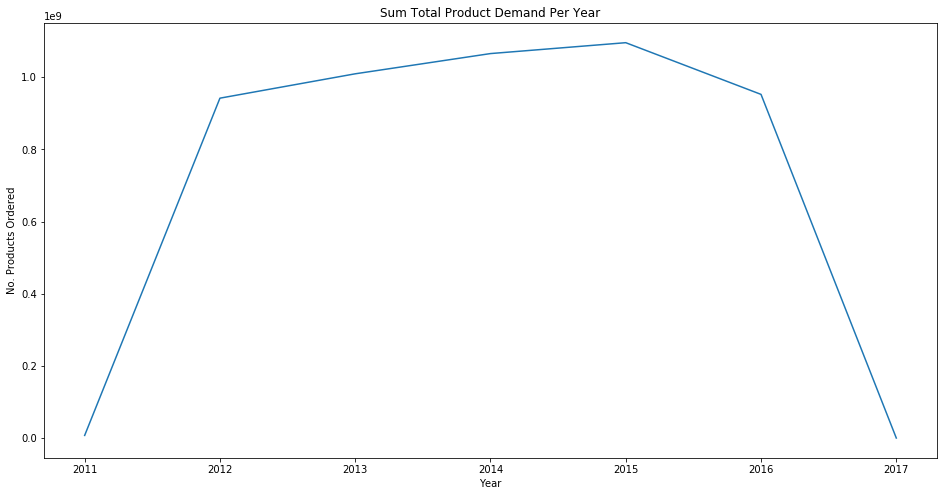

In [18]:
# Plot total product demand vs. year

# Set figure size
plt.figure(figsize=(16,8))
# Plot
plt.plot(ts_yr.index, ts_yr.Order_Demand)
# Title, x & y axis labels
plt.title('Sum Total Product Demand Per Year')
plt.ylabel('No. Products Ordered')
plt.xlabel('Year')
plt.show()

We again can see that demand was significantly lower in 2011 and 2017. I imagine these are either incomplete years or that 2011 was just the beginning, so it took time to gain momentum or perhaps not all of the warehouses were open yet. 

Let's take a closer look to be sure.

In [19]:
# Index time series by year 2011
ts['2011']

,Order_Demand
Date,
2011-01-08,2
2011-05-31,108
2011-06-24,7000
2011-06-24,85000
2011-09-02,1250
...,...
2011-12-30,1000
2011-12-30,4
2011-12-30,1000


We can see that for 2011 we do have all dates/the entire year present. This may indicate the beginning/when the warehouse(s) were brand new or just starting out. Now let's take a look at 2017.

In [20]:
# Index time series by year 2017
ts['2017']

,Order_Demand
Date,
2017-01-02,70
2017-01-03,200
2017-01-03,2000
2017-01-03,200
2017-01-04,10000
2017-01-04,1000
2017-01-04,3000
2017-01-04,1000
2017-01-04,1000


We can see that for this year the data only go through to January 9th, so this is an incomplete year. 

For the sake of our modeling, we will remove 2011 from the data. Again let's visualize that here.

In [21]:
ts_yr

,Order_Demand
Date,
2011,7509986
2012,941742907
2013,1009218798
2014,1065271479
2015,1095426177
2016,952219589
2017,294701


We can see that for those years with data for every day, which are years 2012-2016, the order demand is pretty consistent, with 2012 and 2016 being only slightly lower, and 2017 representing only 9 days of the year. 

So let's go ahead and drop 2011 from our dataset.

In [22]:
ts_df = ts_df['2012':]
ts_df.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-01,Product_2166,Whse_S,Category_024,2
2012-01-02,Product_0664,Whse_S,Category_011,20
2012-01-02,Product_1431,Whse_S,Category_019,20000
2012-01-02,Product_1631,Whse_S,Category_019,1000
2012-01-02,Product_1567,Whse_S,Category_019,68000


Looks great! Now we can get to building our baseline model and predicting overall demand. This should be pretty easy to do as we can already see there seems to be an overall consistent amount of demand year over year with all warehouses combined.

As we move further along we can group by warehouse, and depending how many products there are, we can group by product as well. We already know which warehouses are most productive, as we saw early on when we were cleaning and exploring our data.

Let's go ahead and take a look again.

### Warehouse

#### Value Counts

In [23]:
ts_df.Warehouse.value_counts()

Whse_J    715750
Whse_A    142197
Whse_S     87953
Whse_C     42219
Name: Warehouse, dtype: int64

In [24]:
ts_df[ts_df.Warehouse == 'Whse_J']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-04,Product_1056,Whse_J,Category_032,120
2012-01-05,Product_0197,Whse_J,Category_007,100
2012-01-05,Product_0299,Whse_J,Category_015,12
2012-01-05,Product_1359,Whse_J,Category_019,5000
2012-01-05,Product_0943,Whse_J,Category_005,1000
...,...,...,...,...
2017-01-06,Product_1453,Whse_J,Category_019,8000
2017-01-06,Product_1970,Whse_J,Category_005,2000
2017-01-06,Product_1241,Whse_J,Category_019,20000


#### Order Demand

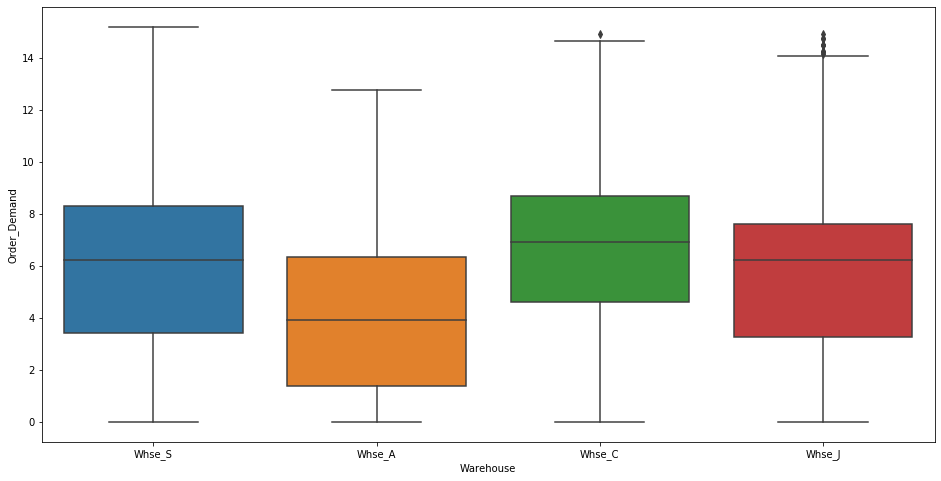

In [25]:
# Set figure size
plt.figure(figsize=(16,8))
# Box plot
sns.boxplot(ts_df['Warehouse'], np.log1p(ts_df['Order_Demand']))
plt.show()

We can see the order here of the most productive warehouses, with J and A in the lead. J by a landslide. S and C being much lower in production. Possibly smaller and servicing more satelite regions. 

Let's take a look at the same, but for products. 

### Products

In [26]:
ts_df.Product_Code.value_counts()

Product_1359    16786
Product_1295    10406
Product_1378     9574
Product_0620     8948
Product_1286     8792
                ...  
Product_0244        1
Product_0465        1
Product_0233        1
Product_1703        1
Product_2099        1
Name: Product_Code, Length: 2157, dtype: int64

Right away we can see there are some products at the bottom that only have 1 entry. My first thought is that these products should be eliminated. However, they could have been newly introduced in January of 2017 and thus would not have a long record and/or they could have high order numbers and perhaps represent a custom order. Let's take a closer look.

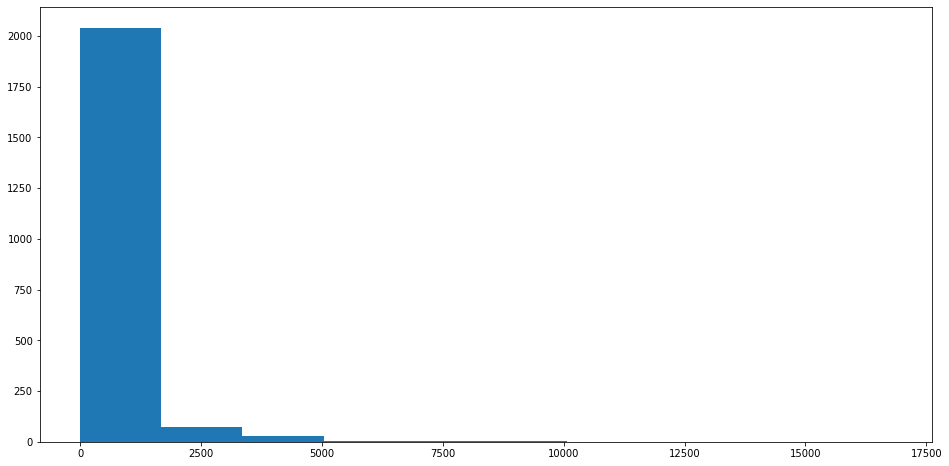

In [27]:
plt.figure(figsize=(16,8))
plt.hist(ts_df.Product_Code.value_counts());

Again my intuition in looking at this histogram is that it would be wise to focus only on the highest demand products and cut the rest. I will go into more detail later on how this will save time/money/floorspace as well as improve/increase efficiency. 

In [28]:
# Let's look at lifetime demand of each product

ts_df_prod = ts_df.groupby(by=ts_df.Product_Code).sum()
ts_df_prod = ts_df_prod.sort_values(by='Order_Demand')
ts_df_prod

,Order_Demand
Product_Code,
Product_1698,2
Product_1703,2
Product_0465,3
Product_2151,5
Product_0466,15
...,...
Product_1295,121852300
Product_1341,166411000
Product_0083,210303000


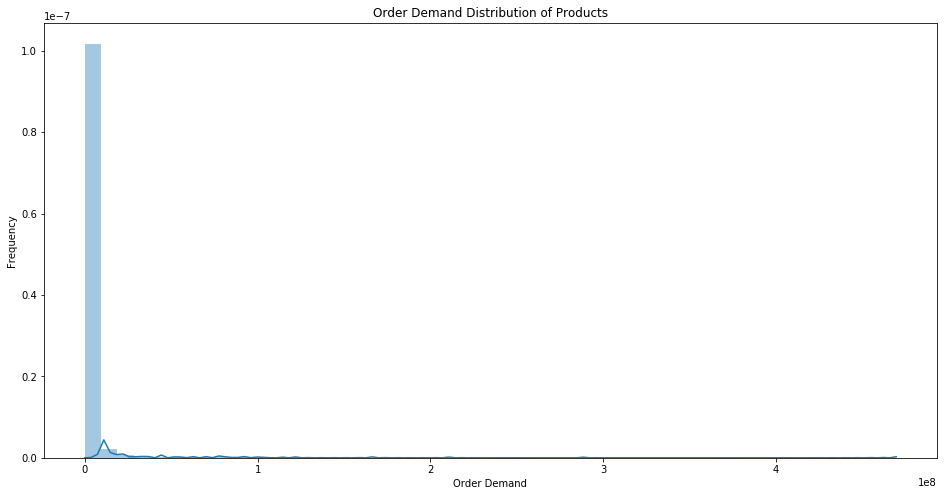

In [29]:
# Sort values in descending order
ts_df_prod = ts_df_prod.sort_values(by='Order_Demand', ascending=False)

# Plot
# Set figure size
plt.figure(figsize=(16,8))
# Plot
sns.distplot(ts_df_prod.Order_Demand)
# Title, x & y axis labels
plt.title('Order Demand Distribution of Products')
plt.ylabel('Frequency')
plt.xlabel('Order Demand')
plt.show()

We can see here visually that a small percentage of available products make up a very large proportion of orders. (Note: Order Demand on x-axis is x 1e<sup>8</sup>.) If we had more detailed information such as profits from each product, we could do a more detailed analysis here to make suggestions on which products to cut from which warehouses.

In an even more detailed analysis it would be good to know footprint of the warehouse as well as number of employees and cost of employees so we could see where things could be culled down and streamlined. How much money can be saved and profits increased. 

If warehouses were to focus on fewer products which make up the greatest amount of orders/profit, could they then hold more stock of the most popular product and increase demand in other ways, such as advertising and saving money on larger purchase orders/more stock/inventory held? 

I will also discuss this in future work. 

In [30]:
ts_df_prod[ts_df_prod.Order_Demand <= 50]

,Order_Demand
Product_Code,
Product_1950,45
Product_1934,42
Product_0467,38
Product_2147,38
Product_1697,28
Product_1773,27
Product_1793,24
Product_0638,22
Product_0633,21


Let's take a closer look at some of these individual products to gain insights into the products, categories, warehouses and anything else we may gather.

In [31]:
ts_df[ts_df.Product_Code == 'Product_1698']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-10-12,Product_1698,Whse_A,Category_021,1
2016-08-29,Product_1698,Whse_A,Category_021,1


In [32]:
ts_df[ts_df.Product_Code == 'Product_1703']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2015-10-08,Product_1703,Whse_A,Category_021,2


In [33]:
ts_df[ts_df.Product_Code == 'Product_0465']

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2016-08-02,Product_0465,Whse_A,Category_012,3


It appears some of these have very sparse orders. These are the lowest demand products. They don't have recent dates and some also have very spread out dates, so they wouldn't have been low demand due to them being a brand new product.

So far they're all from Warehouse A, which is the second highest producing warehouse, so it wouldn't make sense for them to carry these products that have very little demand, yet take up valuable space.

Again it would only make sense if they were high paying custom orders or something related. 

Let's take a look at product category as well to see if we can gain further insight into the categories of products.

### Product Category

In [34]:
ts_df.Product_Category.value_counts()

Category_019    454703
Category_005     95408
Category_001     90489
Category_007     77107
Category_021     48666
Category_006     33084
Category_028     29570
Category_015     22046
Category_011     21351
Category_024     20345
Category_009     19056
Category_026     13694
Category_030     12677
Category_032      8739
Category_022      8532
Category_023      7471
Category_018      4964
Category_003      4051
Category_020      3466
Category_013      3431
Category_031      2139
Category_033      1842
Category_008      1435
Category_012      1115
Category_010       970
Category_029       671
Category_017       576
Category_004       324
Category_002        77
Category_016        37
Category_025        35
Category_027        26
Category_014        22
Name: Product_Category, dtype: int64

Let's visualize this!

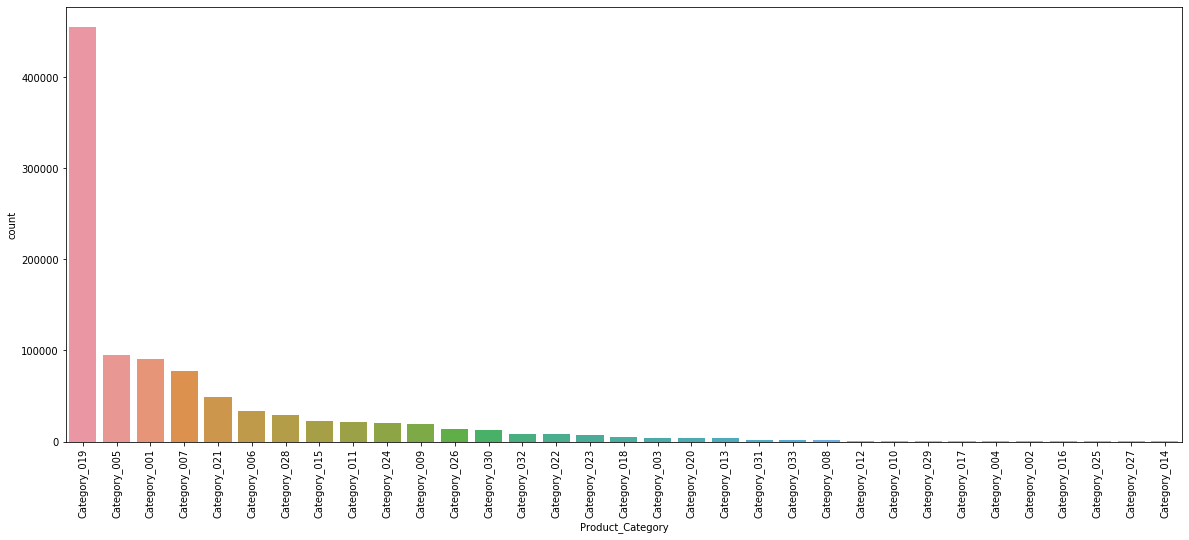

In [35]:
plt.figure(figsize=(20,8))
sns.countplot(x='Product_Category', 
              data=ts_df,
              order = ts_df['Product_Category'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

Category 19 is by far the most in demand product. We can see it really taper off, especially when the lifetime demand for an entire category over the span of approximately 6 years is less than 100. 

Intuitively I would recommend nixing these products. However, if they are extremely high profit products, they may be able to be justified, however that is a far stretch with such low demand over around 6 years, assuming the products have been there since the beginning. 

Another thing to consider is as these are value counts this is essentially all of the days the products were ordered. There could be different amounts of the product ordered each day, which is represented by 'Order Demand'. We'll take a look at that next.

In [36]:
# Lifetime demand of each product category

ts_df_cat = ts_df.groupby(by=ts_df.Product_Category).sum()
ts_df_cat = ts_df_cat.sort_values(by='Order_Demand', ascending=False)
ts_df_cat

,Order_Demand
Product_Category,
Category_019,4194588857
Category_006,392510975
Category_005,194345175
Category_007,127081252
Category_028,46854126
Category_033,42360000
Category_030,39961526
Category_032,4400792
Category_021,4286884


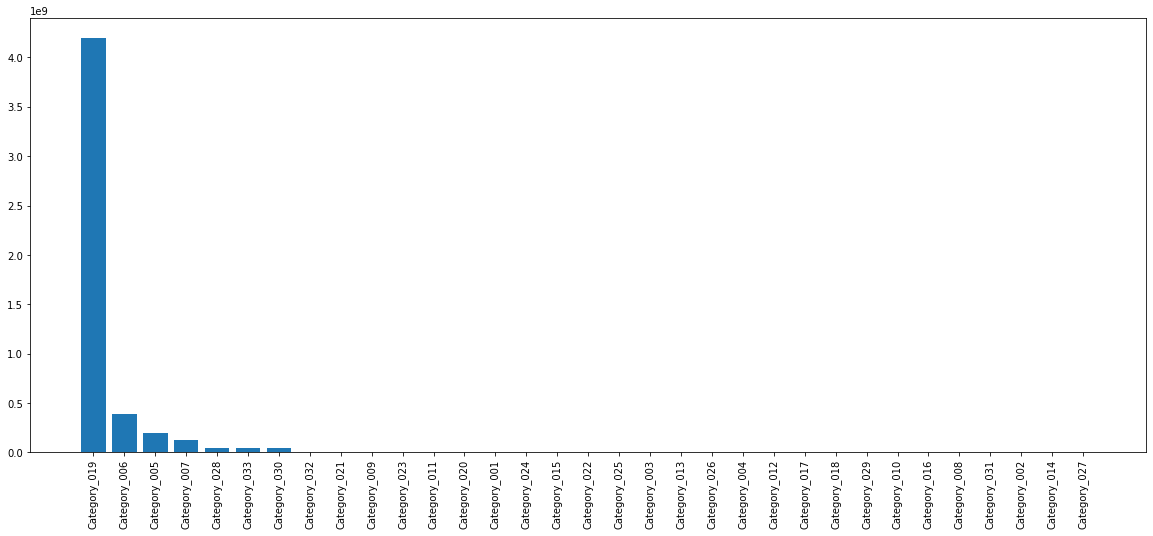

In [37]:
# Set variables and labels 

# x-labels
labels = ts_df_cat.index
# x-values
products = list(range(0,len(labels)))
# y-values
order_demand = ts_df_cat.Order_Demand

# Plot 
# Set figure
plt.figure(figsize=(20,8))
# Plot
plt.bar(products, order_demand, align='center')
# Add labels & rotate 90 degrees
plt.xticks(products, labels, rotation = 90)
plt.show()

We can see all other categories are dwarfed by the demand for category 19. Let's zoom in.

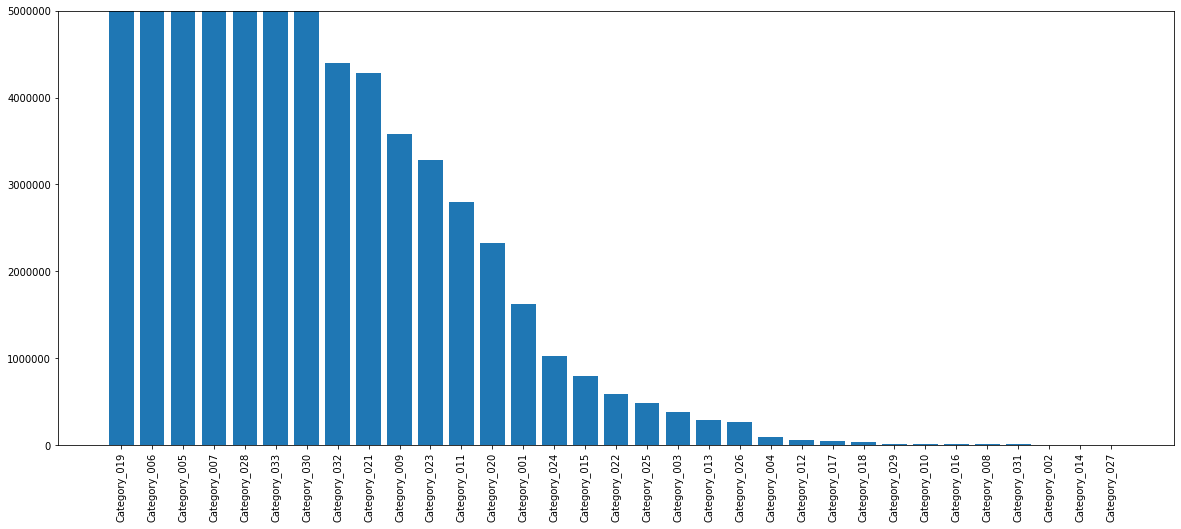

In [38]:
# Plot 
# Set figure
plt.figure(figsize=(20,8))
# Plot
plt.bar(products, order_demand, align='center')
# Add labels & rotate 90 degrees
plt.xticks(products, labels, rotation = 90)
plt.ylim((0,5000000))
plt.show()

In [39]:
cat19 = ts_df[ts_df.Product_Category == 'Category_019']
cat19

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-01-02,Product_1431,Whse_S,Category_019,20000
2012-01-02,Product_1631,Whse_S,Category_019,1000
2012-01-02,Product_1567,Whse_S,Category_019,68000
2012-01-02,Product_1355,Whse_S,Category_019,5000
2012-01-02,Product_1234,Whse_S,Category_019,40000
...,...,...,...,...
2017-01-06,Product_1274,Whse_J,Category_019,20000
2017-01-06,Product_1316,Whse_J,Category_019,10000
2017-01-06,Product_1453,Whse_J,Category_019,8000


In [40]:
cat19.groupby(by=cat19.Warehouse).sum()

,Order_Demand
Warehouse,
Whse_A,103751441
Whse_C,516689533
Whse_J,2706052291
Whse_S,868095592


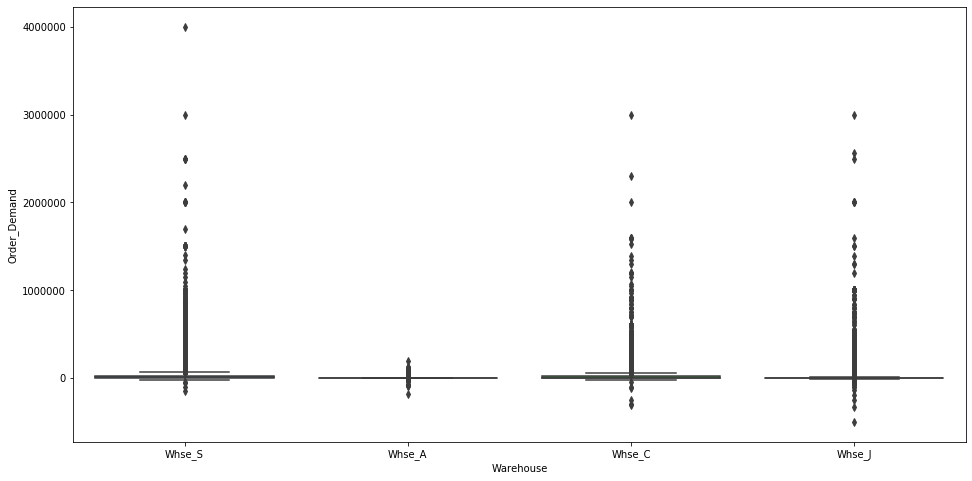

In [41]:
# Plot a box plot of order demand by warehouse for the most
# popular category of product

# Set figure size
plt.figure(figsize=(16,8))
# Box plot
sns.boxplot(y='Order_Demand', x='Warehouse', data=cat19)
plt.show()

Let's take the log so we can get a better view of these. 

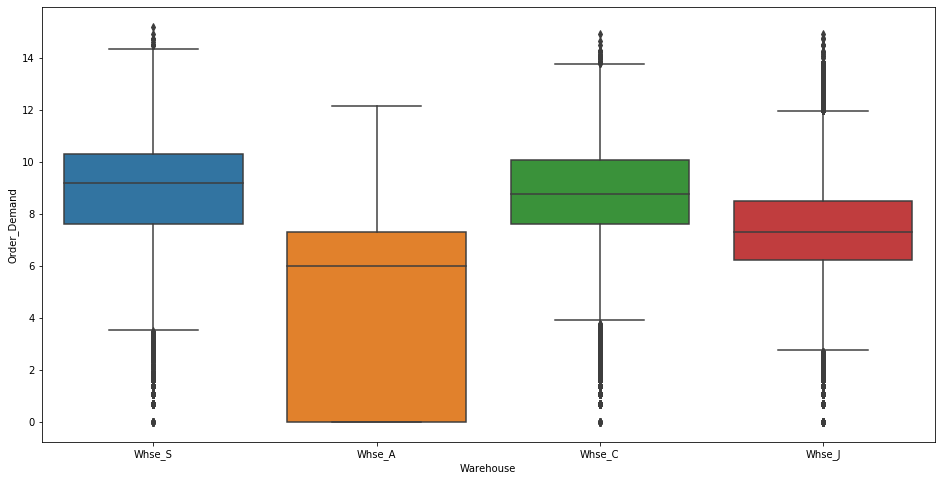

In [42]:
# Set figure size
plt.figure(figsize=(16,8))
# Box plot
sns.boxplot(cat19['Warehouse'], np.log1p(cat19['Order_Demand']))
plt.show()

# Modeling 

## Build & Fit Baseline Model

In [43]:
# ### Convert to FB Prophet Format ###

# # Columns to drop
# to_drop = ['Product_Code','Warehouse','Product_Category']
# # Drop specified columns
# ts_df = ts_df.drop(to_drop, axis=1)
# # Move datetime index to column
# ts_df.reset_index(inplace=True)
# # Rename columns for fbprophet format
# ts_df = ts_df.rename(columns={'Date':'ds', 'Order_Demand': 'y'})

In [53]:
len(ts_df.Product_Category.value_counts())

33

In [51]:
ts_df.groupby(['Product_Category','Date']).sum()

Order_Demand
Product_Category Date                    
Category_001     2012-01-02           107
                 2012-01-03            25
                 2012-01-04            12
                 2012-01-05          1071
                 2012-01-06          1489
...                                   ...
Category_033     2016-12-16         20000
                 2016-12-19         70000
                 2016-12-21         20000
                 2016-12-22        190000
                 2016-12-26         10000

[31357 rows x 1 columns]

In [46]:
# m = Prophet()
# m.fit(ts_df)

In [ ]:
# Forcasting 3 months into the future
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

## Forecasting & Predictions

## Discussion

# Conclusion

## Results

## Recommendations

## Future Work